In [1]:
cd ../marathon/

/home/ubuntu/boston-marathon/marathon


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import marathonlib

In [3]:
def plot_model_deviation(model, X_train, y_train, X_test, y_test, y_max = 0.04):
    print 'Train R^2:', model.score(X_train, y_train)
    print 'Test R^2:', model.score(X_test, y_test)
    y_predict = model.predict(X_test)
    print 'Standard Error of Test:', marathonlib.time_to_timestring(np.var(y_test-y_predict)**0.5)
    plt.hist(y_test-y_predict, bins=100, range=(-100,250), normed=True, linewidth=0)
    plt.xlim(-100, 250)
    plt.ylim(0, y_max)
    plt.vlines(0, 0, 1)

In [4]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [5]:
df = pd.read_csv('data/boston2015_priors+.csv')
df15 = pd.read_csv('data/boston2015_clean.csv')

In [6]:
print df.shape

(101850, 26)


In [7]:
df.columns

Index([u'marathon', u'year', u'bib', u'name', u'firstname', u'lastname',
       u'age', u'gender', u'city', u'state', u'country', u'citizenship',
       u'offltime', u'prior_marathon', u'prior_year', u'prior_time', u'elite',
       u'qualifier', u'home', u'avgtemp', u'avghumid', u'avgwind', u'avgwindE',
       u'avgwindN', u'isgusty', u'rainhours'],
      dtype='object')

In [8]:
df15.columns

Index([u'marathon', u'year', u'bib', u'url', u'name', u'firstname',
       u'lastname', u'age', u'gender', u'city', u'state', u'country',
       u'citizenship', u'subgroup', u'gunstart', u'starttime', u'time5k',
       u'time10k', u'time15k', u'time20k', u'timehalf', u'time25k', u'time30k',
       u'time35k', u'time40k', u'pace', u'projtime', u'offltime', u'nettime',
       u'overall_rank', u'gender_rank', u'division_rank', u'other1', u'other2',
       u'other3', u'other4'],
      dtype='object')

In [9]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_unique_runners(df, func=np.median):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        if len(runners > 1):
            runner['prior_year'] = func(runners['year'])
            runner['prior_marathon'] = ''
            runner['prior_time'] = func(runners['prior_time'])
        runners_list.append(runner)
    #unique_df = pd.concat(runners_list, axis=1).T
    unique_df = pd.DataFrame().append(runners_list)
    return unique_df

In [10]:
sum(df['prior_time'].isnull())

0

In [11]:
unique_df = get_unique_runners(df).copy()
print unique_df.shape

(22724, 26)


In [12]:
len(df['prior_marathon'].unique())

922

In [13]:
print '# of prior records:', len(df)
print '# of unique runners w/priors:', len(unique_df)
print '# of runners in 2015:', len(df15)
print '2015 Runners found: {:.1f}%'.format(len(unique_df) * 100. / len(df15))

# of prior records: 101850
# of unique runners w/priors: 22724
# of runners in 2015: 26403
2015 Runners found: 86.1%


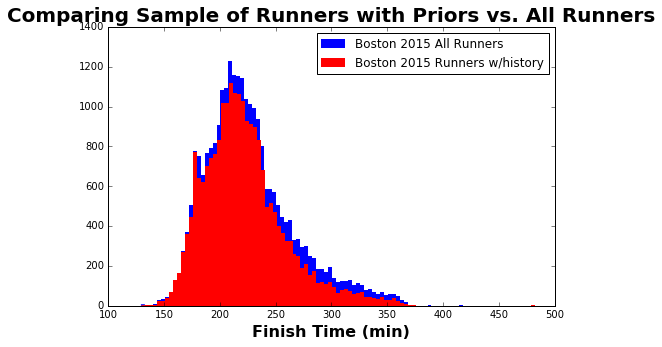

Boston 2015 w/priors: 221.729488136
Boston 2015: 226.339677309


In [14]:
# Finish times of Boston compared with priors
fig = plt.figure(figsize=(8, 5))
plt.hist(df15['offltime'], bins=100, label='Boston 2015 All Runners', linewidth=0, color='b')
plt.hist(unique_df['offltime'], bins=100, label='Boston 2015 Runners w/history', linewidth=0, color='r')
plt.legend()
plt.title('Comparing Sample of Runners with Priors vs. All Runners', fontsize=20, weight='bold')
plt.xlabel('Finish Time (min)', fontsize=16, weight='bold')
plt.savefig('test.png', transparent=True)
plt.show()
print 'Boston 2015 w/priors:', df['offltime'].mean()
print 'Boston 2015:', df15['offltime'].mean()

Even though we've captured 86+% of runners, the averages are off.  Is it possible our missing runners are runners who do not run marathons, and are running a professional course for the first time?

# of bib numbers with no priors:  3640


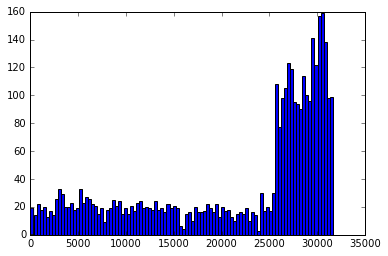

In [15]:
priorbibs = set(df['bib'])
missing_bibs = [bib for bib in df15['bib'] if bib not in priorbibs]
print '# of bib numbers with no priors: ', len(missing_bibs)
plt.hist(missing_bibs, bins=100)
plt.show()

For 2015, non-qualifiers were assigned bib numbers > ~26,000 (aka Charity runners).  It appears a chunk of our runners are indeed first timers.  But we are missing running histories for other runners too.

### Build Dataframe for Modelling

In [16]:
# One row per running record.  We will combine runner predictions later
feature_columns = [# u'bib', 
                   u'age', u'gender', u'elite', u'qualifier', 
                   u'home', 
                   u'avgtemp', u'avghumid', u'avgwind', u'avgwindE', u'avgwindN', u'isgusty',
                   u'rainhours','prior_year', 'prior_time', 'prior_marathon']
#model_df = pd.get_dummies(unique_df[feature_columns])
model_df = pd.get_dummies(df[feature_columns])
X = model_df.values
y = df['offltime'].values
print X.shape, y.shape

(101850, 995) (101850,)


### Mean as a Model

Train R^2: 0.0
Test R^2: 0.0
Standard Error of Test: 0:36:48


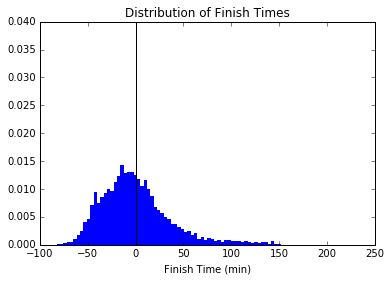

In [17]:
model = DummyRegressor()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

### Regression Model

Train R^2: 0.530249548094
Test R^2: 0.530249548094
Standard Error of Test: 0:25:13


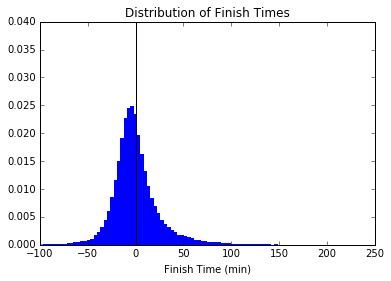

In [18]:
model = LinearRegression()
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

Train R^2: 0.479956059411
Test R^2: 0.479956059411
Standard Error of Test: 0:26:32

Lasso Coefficients (alpha= 1 )
------------------
intercept 323.712142901
age       1.06872162082
gender    -12.3339495476
avgtemp   -0.0485836234116
avghumid  0.0013544849561
avgwind   0.0137005751691
avgwindE  -0.0330972333447
avgwindN  0.0383303539118
prior_year-0.114056223707
prior_time0.393408485799
home_MA   4.50827581385


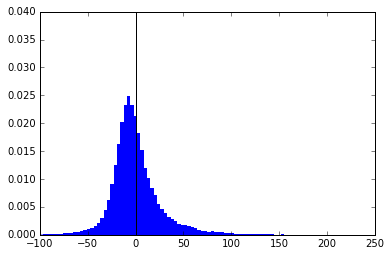

In [19]:
alpha = 1
model = Lasso(alpha=alpha)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
print 
print 'Lasso Coefficients (alpha=',alpha,')'
print '------------------'
print '{0:10}{1}'.format('intercept', model.intercept_)
for name, coef in zip(model_df.columns, model.coef_):
    if abs(coef) > 0.001:
        print '{0:10}{1}'.format(name, coef)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=732)
print X_train.shape, y_train.shape

(76387, 995) (76387,)


In [21]:
print X_test.shape, y_test.shape

(25463, 995) (25463,)


Train R^2: 0.606936896171
Test R^2: 0.592033992122
Standard Error of Test: 0:23:35


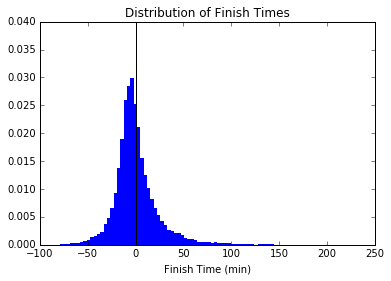

In [22]:
model = GradientBoostingRegressor(n_estimators=200, learning_rate = 0.04, max_depth=4, subsample=0.6)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

Train R^2: 0.442397288565
Test R^2: 0.413123557975
Standard Error of Test: 0:28:17


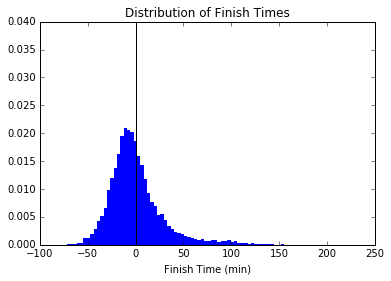

In [23]:
model = RandomForestRegressor(max_depth = 16, max_features = 43, n_estimators = 1000)
model.fit(X_train, y_train)
plot_model_deviation(model, X_train, y_train, X_test, y_test)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('priormodel-randomforest.png', bbox_inches='tight', dpi=300)
plt.show()

# Pick model

Since we need to train on entire dataset and use the results, we need a model that does not overfit.

### Gradient Boosting Wins

## 1. Tune Gradient Boosting

In [24]:
# Tune using CV search
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [100],
#                                  'learning_rate': [0.04],
#                                  'max_depth': [4],
#                                  'subsample': [0.7, 0.6, 0.5]},
#                      verbose=True)
# model.fit(X_train, y_train)
# print model.best_params_

In [25]:
# Bump up the number of estimators and now tune learning_rate
# model = GridSearchCV(GradientBoostingRegressor(verbose=True), 
#                      param_grid={'n_estimators': [500],
#                                  'learning_rate': [0.04, 0.01, 0.003, 0.001],
#                                  'max_depth': [4],
#                                  'subsample': [0.6]},
#                      verbose=True)
# model.fit(X, y)
# print model.best_params_
# plot_model_deviation(model, X, y, X, y)
# plt.title('Distribution of Finish Times')
# plt.xlabel('Finish Time (min)')
# plt.show()

## 2. Fit on entire dataset (- extreme outliers)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1312.9507          51.9293           60.59m
         2        1251.6175          48.9108           60.61m
         3        1206.2288          44.8273           60.43m
         4        1161.7202          41.7911           60.30m
         5        1125.4292          38.3480           60.21m
         6        1095.8183          35.4939           60.15m
         7        1050.8100          32.9322           59.98m
         8        1017.3852          30.8680           59.85m
         9         996.5482          28.5178           59.74m
        10         973.3696          26.3010           59.63m
        20         784.0790          13.2415           58.30m
        30         701.7935           6.3408           56.94m
        40         648.5409           3.7844           55.58m
        50         606.5113           2.2547           54.29m
        60         598.6670           1.3803           53.00m
       

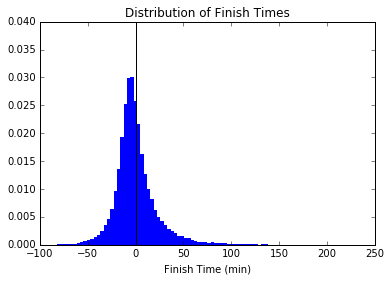

In [26]:
model = GradientBoostingRegressor(n_estimators=500, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X, y)
plot_model_deviation(model, X, y, X, y)
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.show()

In [ ]:
# Remove outliers > 3 std deviations away
y_predict = model.predict(X)
stddev = np.var(y - y_predict)**0.5
outlier = abs(y-y_predict) > 3*stddev

X_clean = model_df[~outlier].values
y_clean = df.loc[~outlier, 'offltime'].values
print X_clean.shape, y_clean.shape

(99989, 995) (99989,)


In [ ]:
# Refit model without outliers
model = GradientBoostingRegressor(n_estimators=500, learning_rate = 0.04, max_depth=4, subsample=0.6, verbose=True)
model.fit(X_clean, y_clean)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1114.9151          52.2194           59.51m
         2        1068.9273          47.5732           59.37m
         3        1023.1840          44.3614           59.26m
         4         983.5630          41.4055           59.17m
         5         949.1784          37.6306           59.01m
         6         913.0258          35.3838           58.92m
         7         878.6884          32.2469           58.73m
         8         856.4745          30.2464           58.67m
         9         828.5302          28.5236           58.48m
        10         796.4562          27.2383           58.38m
        20         608.0612          12.7861           57.09m
        30         515.8286           6.7691           55.85m
        40         463.0977           3.7741           54.58m
        50         431.9179           2.2842           53.27m
        60         414.3402           1.5499           51.95m
       

Train R^2: 0.707755039105
Test R^2: 0.707755039105
Standard Error of Test: 0:18:30


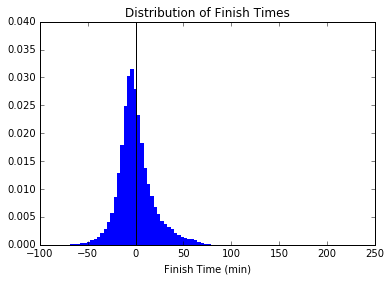

In [33]:
plot_model_deviation(model, X_clean, y_clean, X_clean, y_clean)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('finalmodel-gradientboosting.png', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
feature_importance = zip(model_df.columns, model.feature_importances_)
sorted(feature_importance, reverse=True, key=lambda x: x[1])[0:20]

[('prior_time', 0.29092112412444526),
 ('age', 0.13446577416978922),
 ('gender', 0.031543651119641615),
 ('avgtemp', 0.02472543029736101),
 ('home_MA', 0.023920849584780281),
 ('home_AUS', 0.023596016627712005),
 ('prior_year', 0.016291117577411016),
 ('prior_marathon_boston', 0.014098245897082475),
 ('avghumid', 0.012027118254926396),
 ('avgwind', 0.010921402870030393),
 ('avgwindN', 0.0099971622036365334),
 ('home_FL', 0.0099400398763288978),
 ('home_CAN', 0.0088485704046097589),
 ('home_UT', 0.0084512573679388896),
 ('prior_marathon_london', 0.0072893908474745998),
 ('avgwindE', 0.0069313198151280181),
 ('home_MISC', 0.0066785031982881009),
 ('prior_marathon_leadville_trail', 0.0065799029123110265),
 ('home_AZ', 0.0065124486678265108),
 ('prior_marathon_moab_trail', 0.0064644325288047309)]

## 3. Select outliers.

Train R^2: 0.610233373607
Test R^2: 0.610233373607
Standard Error of Test: 0:22:55


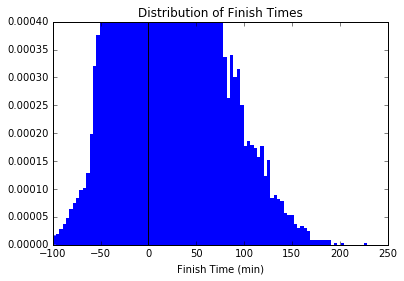

In [35]:
# Plot showing outliers
plot_model_deviation(model, X, y, X, y, y_max = 0.0004)
plt.title('Distribution of Finish Times')
plt.xlabel('Finish Time (min)')
plt.savefig('outliers-zoom.png', bbox_inches='tight', dpi=300)
plt.show()

In [36]:
y_predict = model.predict(X)

In [37]:
model_df['predicted_time'] = y_predict

In [38]:
cheaters = pd.read_csv('data/boston2015_cheaters.csv')
cheaters = set(cheaters['bib'])
print len(cheaters)

58


In [39]:
stddev = np.var(y - y_predict)**0.5
outliers = (y - y_predict > 1 * stddev)
outlier_bibs = df.loc[outliers, 'bib'].unique()

print 'Standard Error:', stddev
print '# of outlier records:', sum(outliers)
print
print 'Total # of unique runners:', len(df['bib'].unique())
print '# of cheaters in our unique runners:', len([bib for bib in df['bib'].unique() if bib in cheaters])
print 'Cheating rate in our runners: {:.2f}%'.format(len([bib for bib in df['bib'].unique() if bib in cheaters]) * 100. 
                                                     / len(df['bib'].unique()))
print '# of unique outliers:', len(df.loc[outliers, 'bib'].unique())
print '# of cheaters in our outliers:', len([bib for bib in outlier_bibs if bib in cheaters])
print 'Cheating rate in our outliers: {:.2f}%'.format(len([bib for bib in outlier_bibs if bib in cheaters]) * 100. 
                                                      / len(df.loc[outliers, 'bib'].unique()))


Standard Error: 22.9244971753
# of outlier records: 11982

Total # of unique runners: 22724
# of cheaters in our unique runners: 49
Cheating rate in our runners: 0.22%
# of unique outliers: 3877
# of cheaters in our outliers: 40
Cheating rate in our outliers: 1.03%


In [40]:
# remove duplicate runners from priors+, results from runners who have ran more than one other race.
def get_uniques(df):
    unique_bibs = df['bib'].unique()
    runners_list = []
    for bib in unique_bibs:
        runners = df[df['bib'] == bib]
        runner = runners.iloc[0].copy()
        runner['predicted'] = np.mean((runners['predicted']))
        runner['difference'] = runner['offltime'] - runner['predicted']
        runner['median_difference'] = runner['offltime'] - np.median((runners['predicted']))
        runner['min_difference'] = runner['offltime'] - np.min((runners['predicted']))
        runner['max_difference'] = runner['offltime'] - np.max((runners['predicted']))
        if len(runners) > 1:
            # If multiple records exist for a runner, then save the following columns
            runner['2ndmin_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[1]
            runner['2ndmax_difference'] = runner['offltime'] - list(runners['predicted'].sort_values())[-2]
        else:
            runner['2ndmin_difference'] = runner['difference']
            runner['2ndmax_difference'] = runner['difference']
        runners_list.append(runner)
    unique_df = pd.DataFrame(runners_list)
    return unique_df

In [43]:
# Make cheater prediction table
# bib, y, y_predict, cheater
predict_df = pd.DataFrame(df['bib'])
predict_df['offltime'] = y
predict_df['predicted'] = y_predict
predict_df['difference'] = y - y_predict
predict_df['cheater'] = df['bib'].isin(cheaters)
print predict_df.shape
predict_df = get_uniques(predict_df)
print predict_df.shape

(101850, 5)
(22724, 10)


In [44]:
print predict_df['difference'].min(), predict_df['difference'].max()

-81.6888332218 214.926802319


In [45]:
from sklearn.metrics import roc_auc_score, roc_curve

In [46]:
print roc_auc_score(predict_df['cheater'], predict_df['difference'])
print roc_auc_score(predict_df['cheater'], predict_df['median_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['min_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['2ndmin_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['max_difference'])
print roc_auc_score(predict_df['cheater'], predict_df['2ndmax_difference'])

0.850872353351
0.847907656999
0.868154715028
0.844607249736
0.80231847535
0.833533289832


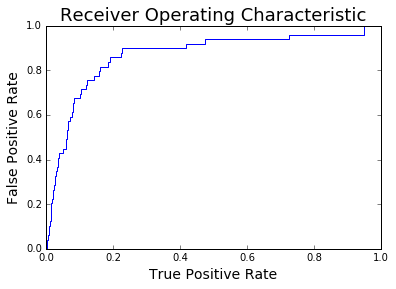

In [51]:
fprs, tprs, thresholds = roc_curve(- predict_df['cheater'], predict_df['min_difference'])
plt.plot(tprs, fprs)
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.xlabel('True Positive Rate', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.savefig('roc_curve.png', bbox_inches='tight', dpi=300)
plt.show()


In [52]:
print 'Overall'
print '{}/{} ({:.2f}%)'.format(sum(predict_df['cheater']), len(predict_df), sum(predict_df['cheater']) * 100. / len(predict_df))
print
out_str = '{:9.1f}  {:5.3f}  {:5.3f}  {:8}  {:7}  {:4.2f}'
print 'threshold   tpr    fpr   cheaters  records  rate'
print '---------  -----  -----  --------  -------  ----'
for i in range(70, 90):
    threshold = thresholds[i]
    flagged = predict_df.loc[predict_df['min_difference'] > threshold, 'cheater']
    print out_str.format(thresholds[i], tprs[i], fprs[i], sum(flagged), len(flagged), sum(flagged) * 100. / len(flagged))
    

Overall
49/22724 (0.22%)

threshold   tpr    fpr   cheaters  records  rate
---------  -----  -----  --------  -------  ----
     30.4  0.119  0.735        35     2744  1.28
     30.0  0.122  0.735        36     2802  1.28
     30.0  0.122  0.755        36     2803  1.28
     26.5  0.143  0.755        37     3271  1.13
     26.4  0.143  0.776        37     3272  1.13
     24.4  0.158  0.776        38     3609  1.05
     24.4  0.158  0.796        38     3610  1.05
     24.2  0.159  0.796        39     3649  1.07
     24.2  0.159  0.816        39     3650  1.07
     21.2  0.185  0.816        40     4229  0.95
     21.2  0.185  0.837        40     4230  0.95
     20.6  0.190  0.837        41     4347  0.94
     20.6  0.190  0.857        41     4348  0.94
     17.3  0.224  0.857        42     5116  0.82
     17.3  0.224  0.878        42     5117  0.82
     17.2  0.225  0.878        43     5154  0.83
     17.2  0.225  0.898        43     5155  0.83
     14.8  0.258  0.898        44     5890 

In [49]:
# Set threshold at 30.0 min
threshold = 30.0
flagged = predict_df.loc[predict_df['max_difference'] > threshold, 'cheater']
out_str = '{:9.1f}  {:8}  {:7}  {:4.2f}'
print 'threshold  cheaters  records  rate'
print '---------  --------  -------  ----'
print out_str.format(threshold, sum(flagged), len(flagged), sum(flagged) * 100. / len(flagged))

threshold  cheaters  records  rate
---------  --------  -------  ----
     30.0        26     1622  1.60


In [50]:
print 8229 in cheaters
runners = predict_df[predict_df['bib'] == 8229]
print runners.T

True
                       172
bib                   8229
offltime             241.7
predicted          215.555
difference         26.1451
cheater               True
median_difference  20.7116
min_difference     45.2275
max_difference     17.9295
2ndmin_difference  23.0908
2ndmax_difference  18.3324


In [ ]:
model_df[model_df['bib'] == 8229].T